In [1]:
cd ../..

/home/jupyter/M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, save_object
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [3]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [4]:
model_dir = 'models/uncertainty/train_multiple_levels/try2/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Model architectures per level

In [10]:
labels = ['demand']

# Set input sizes for the model
input_shapes = {
    1: (178,),
    2: (181,),
    3: (191,),
    4: (181,),
    5: (188,),
    6: (184,),
    7: (191,),
    8: (194,),
    9: (201,),
    10: (3237,),
    11: (3240,),
    12: (3248,),
}

# Set initial batch size
warmup_batch_size = {level: 16 if level <= 9 else 1024 for level in range(1, 1+12)}

# Set fine-tune batch size
finetune_batch_size = {level: 256 if level <= 9 else 25000 for level in range(1, 1+12)}

# select which model function was used to build the model
models_base = {
    1: get_variable_dist_model(inp_shape=input_shapes[1], num_nodes=4, clear_session=True),
    2: get_direct_dist_model(inp_shape=input_shapes[2], num_nodes=6, clear_session=True),
    3: get_simple_dist_model(inp_shape=input_shapes[3], num_nodes=6, clear_session=True),
    4: get_simple_dist_model(inp_shape=input_shapes[4], num_nodes=6, clear_session=True),
    5: get_simple_dist_model(inp_shape=input_shapes[5], num_nodes=6, clear_session=True),
    6: get_simple_dist_model(inp_shape=input_shapes[6], num_nodes=6, clear_session=True),
    7: get_simple_dist_model(inp_shape=input_shapes[7], num_nodes=32, clear_session=True),
    8: get_simple_dist_model(inp_shape=input_shapes[8], num_nodes=32, clear_session=True),
    9: get_simple_dist_model(inp_shape=input_shapes[9], num_nodes=32, clear_session=True),
}

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]


### Setup training

In [11]:
def run_training(models_base, lags=None):
    """"""
    if lags is None:
        lags = [1, 2, 3, 7, 14, 21, 28]
    
    # track metrics
    logger_list = []
    part1_metrics = []
    part2_metrics = []
    part3_metrics = []
    
    overview = pd.DataFrame(columns=['level','prediction lag','part','WSPL'])
    
    # loop over the levels
    for level, model in models_base.items():
        
        # train model
        warmup_lr_list = [1e-3, 1e-3, 1e-3, # save part 1
                          1e-3, 1e-3, 1e-3] # save part 2
        finetune_lr_list = [1e-4, 1e-4, 1e-5, 1e-5]
        
        for prediction_lag in lags:
            
            run_dir = model_dir + 'level_{}/lag_{}/'.format(level, prediction_lag)
            if not os.path.exists(run_dir):
                os.makedirs(run_dir)

            # select model
            # We need to clone as we otherwise build off of the weights
            # of other lags
            model = clone_model(models_base[level])
            
            model_name = "lag{}".format(prediction_lag)
            
            model, logger, metrics1, metrics2, metrics3 = perform_training_scheme(
                level, model, warmup_batch_size, finetune_batch_size, ref, calendar,
                model_dir=run_dir, warmup_lr_list=warmup_lr_list, finetune_lr_list=finetune_lr_list,
                prediction_lag=prediction_lag, model_name=model_name)
            
            # save metrics
            logger_list.append(logger); part1_metrics.append(metrics1);
            part2_metrics.append(metrics2); part3_metrics.append(metrics3)
            for i, m in enumerate([part1_metrics, part2_metrics, part3_metrics]):
                save_object(m, run_dir + 'level' + str(level) + '_' + str(prediction_lag) + "_part{}_metrics.pickle".format(i+1))
                overview_log = pd.DataFrame({"level":[level],"prediction lag":[prediction_lag],"part":[i],"WSPL":[m[0]['WSPL']]})
                overview = overview.append(overview_log)
            
            # save training metrics
            save_object(logger.train_metrics, run_dir + 'level' + str(level) + '_' + model_name + "_metrics_train.pickle")
            save_object(logger.val_metrics, run_dir + 'level' + str(level) + '_' + model_name + "_metrics_val.pickle")
        
    return overview

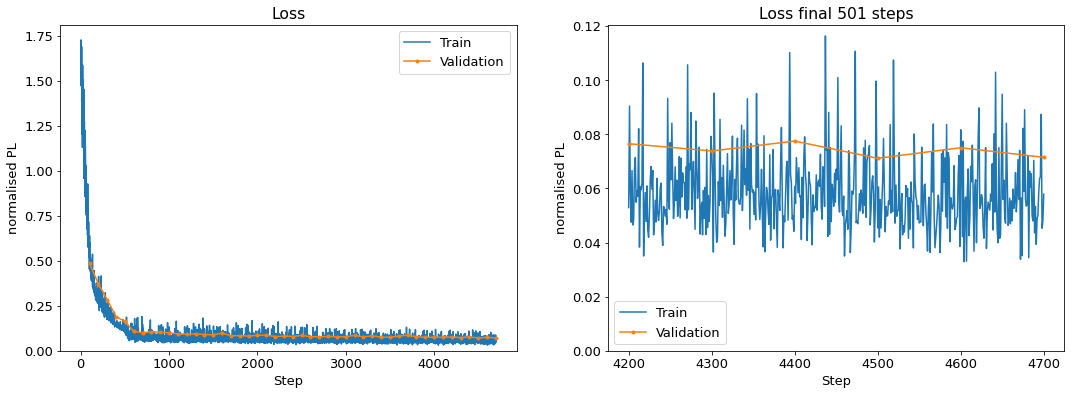

100/100 [==============================] - 5s 52ms/step - loss: 0.0574 - q0_loss: 0.0012 - q1_loss: 0.0024 - q2_loss: 0.0082 - q3_loss: 0.0103 - q4_loss: 0.0132 - q5_loss: 0.0107 - q6_loss: 0.0085 - q7_loss: 0.0023 - q8_loss: 6.0511e-04 - val_loss: 0.0715 - val_q0_loss: 0.0012 - val_q1_loss: 0.0023 - val_q2_loss: 0.0102 - val_q3_loss: 0.0135 - val_q4_loss: 0.0181 - val_q5_loss: 0.0130 - val_q6_loss: 0.0099 - val_q7_loss: 0.0027 - val_q8_loss: 6.9566e-04

Epoch 00008: LearningRateScheduler reducing learning rate to 0.001.
Epoch 8/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0587 - q0_loss: 0.0013 - q1_loss: 0.0026 - q2_loss: 0.0086 - q3_loss: 0.0106 - q4_loss: 0.0131 - q5_loss: 0.0108 - q6_loss: 0.0087 - q7_loss: 0.0024 - q8_loss: 6.6009e-04

In [ ]:
run_training(models_base)

In [13]:
1

1

In [ ]:
import os
import zipfile
def zipdir(path, ziph):
    print(path)
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
            
zipf = zipfile.ZipFile('models.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('./models/uncertainty/train_multiple_levels_lag', zipf)
zipf.close()

./models/uncertainty/train_multiple_levels_lag
